# Rohdatenanalyse elektrischer Daten

* Datenimport


In [24]:
import crtomo
import reda

import matplotlib.pyplot as plt
plt.style.use('default')
import numpy as np
import pandas as pd
import math
from scipy import optimize
from scipy import interpolate

import string
import copy

## Datenimport

In [25]:
path = "p1n.bin"

ERT = reda.ERT()
ERT.import_syscal_bin(path, spacing=5, check_meas_nums=False)

2023-12-13 10:17:02,495 - reda.containers.BaseContainer  - %INFO       - IRIS Syscal Pro bin import
2023-12-13 10:17:03,134 - reda.containers.BaseContainer  - %INFO       - Data sized changed from 0 to 1170


In [26]:
path = "p1r.bin"

ERTr = reda.ERT()
ERTr.import_syscal_bin(path, spacing=5, check_meas_nums=False)

2023-12-13 10:17:03,140 - reda.containers.BaseContainer  - %INFO       - IRIS Syscal Pro bin import
2023-12-13 10:17:03,748 - reda.containers.BaseContainer  - %INFO       - Data sized changed from 0 to 1161


In [27]:
K = reda.utils.geometric_factors.compute_K_analytical(ERT.data, spacing=5)
ERT.apply_k(K)

ERT.data["rhoa"] = ERT.data["r"] * K

Kr = reda.utils.geometric_factors.compute_K_analytical(ERTr.data, spacing=5)
ERTr.apply_k(Kr)

ERTr.data["rhoa"] = ERTr.data["r"] * Kr

## Datenfilter

In [28]:
# ERT.filter("rhoa < 0")
# ERT.filter("rhoa > 80")

## Darstellung der Daten

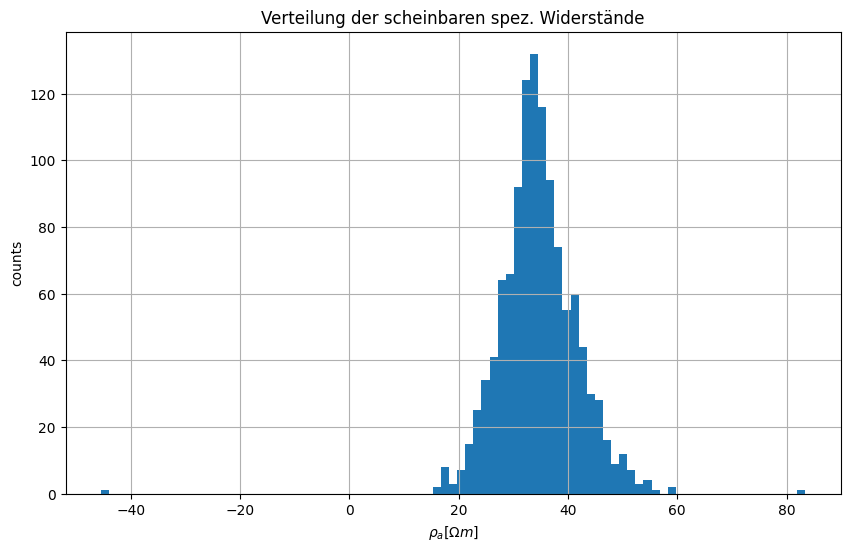

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Verteilung der scheinbaren spez. Widerstände")
ax.hist(ERT.data["rhoa"].values, bins="fd")
ax.set_xlabel(r"$\rho_a [\Omega m]$")
ax.set_ylabel("counts")
ax.grid()

In [30]:
# zu snippet machen

abmn = []

for a, b, m, n in list(ERT.data[["a", "b", "m", "n"]].values):
    
    abmn.append(set([a, b, m, n]))
    
ERT.data["abmn"] = abmn


abmn = []

for a, b, m, n in list(ERTr.data[["a", "b", "m", "n"]].values):
    
    abmn.append(set([a, b, m, n]))
    
ERTr.data["abmn"] = abmn

In [31]:
rec_ids = []

for i in range(len(ERTr.data["abmn"])):
    v = ERTr.data["abmn"].iloc[i]
    ri = int(np.where((ERT.data["abmn"] == v).values)[0][0])
#     print(ri)
    rec_ids.append([ri, i])
rec_ids = np.array(rec_ids)
rec_ids

array([[   0,    0],
       [   1,    1],
       [  39,    2],
       ...,
       [1152, 1158],
       [1163, 1159],
       [1102, 1160]])

In [32]:
norR = ERT.data["r"].iloc[rec_ids[:, 0]].values
recR = ERTr.data["r"].iloc[rec_ids[:, 1]].values
res = norR - recR

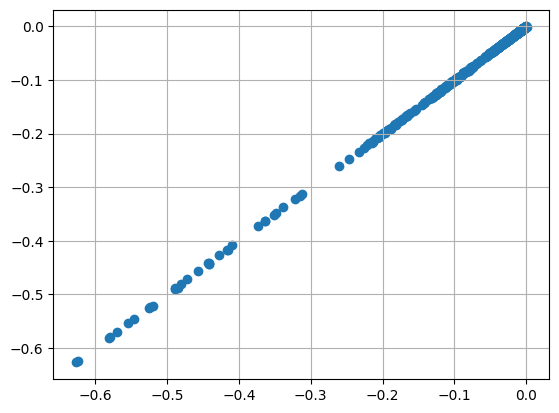

In [33]:
plt.scatter(norR, recR)
plt.grid()
# plt.xscale("log")
# plt.yscale("log")

Text(0, 0.5, 'res')

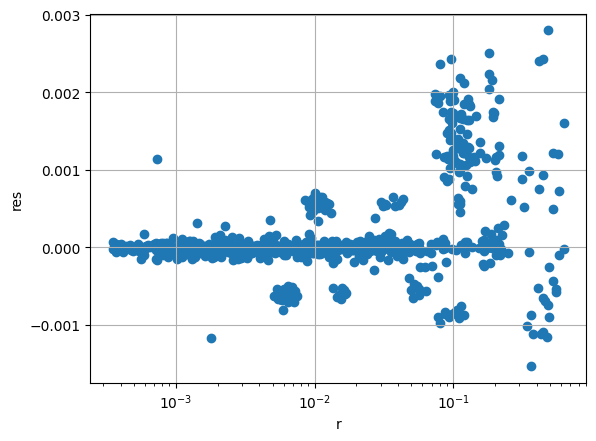

In [34]:
plt.scatter(np.abs(norR), res)
plt.grid()
plt.xscale("log")
plt.xlabel("r")
plt.ylabel("res")

## Fehlerparameter

In [35]:
# error quantification

NBins = 10

def error_model(r, a, b):
    return a * r + b

def log10_error_model(r, a, b):
    return np.log10(error_model(r, a, b))

df = pd.DataFrame(columns=["r", "res"])

df["r"] = np.abs(norR) # hier Werte ergänzen / ersetzen
df["res"] = res # hier Werte ergänzen / ersetzen

df = df.iloc[5:]

out, bins = pd.cut(np.log10(df["r"]), NBins, retbins=True)

bins = 10**bins
bins_edge = bins

new_out = pd.Series([pd.Interval(left=10**interval.left, right=10**interval.right) for interval in out])
for i in range(len(out)):
    out.replace(out.iloc[i], new_out.iloc[i], inplace=True)

df["bin"] = out
res_std = df.groupby("bin").std()["res"].to_numpy()
bins = bins[:-1] + np.diff(bins)/2
bin_counts = df["bin"].value_counts()
bin_counts.index = [lb.left for lb in bin_counts.index]
bin_counts.sort_index(inplace=True)
bin_counts = bin_counts.values

errpopt, errpcov = optimize.curve_fit(log10_error_model,
                                      bins[~np.isnan(res_std)], np.log10(res_std[~np.isnan(res_std)]),
                                      sigma=np.sqrt(bin_counts[~np.isnan(res_std)])**-1)

print(errpopt)

[0.00447469 0.00010445]


/home/mweigand/.virtualenvs/angeo/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == "__main__":


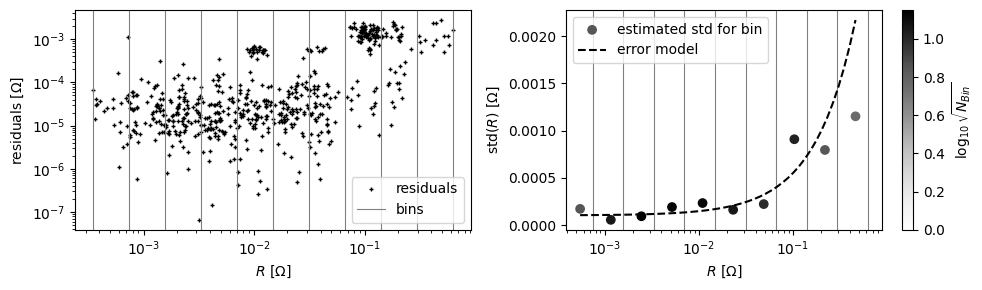

In [36]:
# snippet erstellen

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

ax = axes[0]
ax.plot(np.abs(norR), res, linestyle=" ", marker="+", color="k", label="residuals", markersize=3)

for b in bins_edge[1:]:
    ax.axvline(b, color="grey", linewidth=0.8)
    
ax.axvline(bins_edge[0], color="grey", linewidth=0.8, label="bins")

ax.set_xlabel(r"$R$ [$\Omega$]")
ax.set_ylabel("residuals [$\Omega$]")
ax.legend()

ax.set_xscale("log")
ax.set_yscale("log")

ax = axes[1]
for b in bins_edge[1:]:
    ax.axvline(b, color="grey", linewidth=0.8)
    
mapp = ax.scatter(bins, res_std, c=np.log10(bin_counts**0.5), label="estimated std for bin", cmap="Greys", vmin=0)
ax.plot(np.logspace(np.log10(bins.min()), np.log10(bins.max())), error_model(np.logspace(np.log10(bins.min()), np.log10(bins.max())), *errpopt), label="error model", color="k", linestyle="--")

ax.set_xlabel(r"$R$ [$\Omega$]")
ax.set_ylabel(r"std($R$) [$\Omega$]")
ax.legend()

ax.set_xscale("log")
# ax.set_yscale("log")

fig.colorbar(mapp, ax=ax, label=r"$\log_{10}\,\sqrt{N_{Bin}}$")

fig.tight_layout()

# fig.savefig("figures/bin_analysis.pdf", bbox_inches="tight")

In [37]:
K = reda.utils.geometric_factors.compute_K_analytical(ERT.data, spacing=5)
ERT.apply_k(K)


ERT.data["rhoa"] = ERT.data["r"] * K

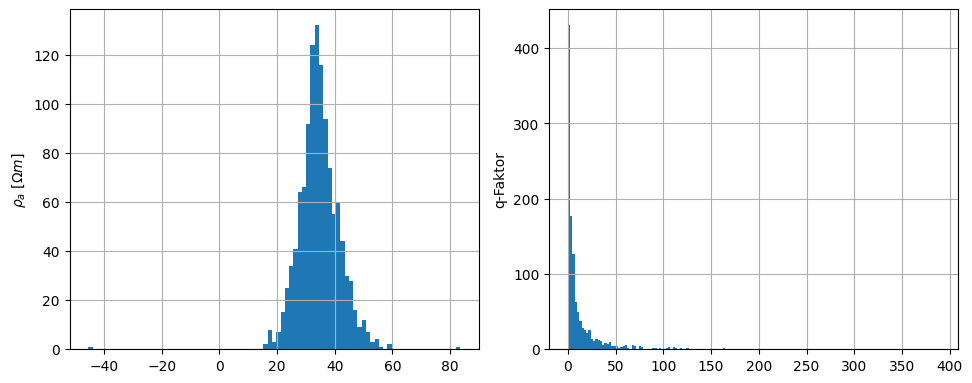

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(25 / 2.54, 10 / 2.54))
ax.set_title('Vor dem Filtern von q-Faktoren', loc='left')

ax = axes[0]
ERT.data["rhoa"].hist(bins="fd", ax=ax)
ax.set_ylabel(r'$\rho_a~[\Omega m]$')
ax = axes[1]
ERT.data["q"].hist(bins="fd", ax=ax)
ax.set_ylabel('q-Faktor')

fig.tight_layout()

In [39]:
# Filtern von wirklich schlechten Qualitätsfaktoren
ERT.filter("q > 20")

2023-12-13 10:17:06,870 - reda.containers.BaseContainer  - %INFO       - Data sized changed from 1170 to 948


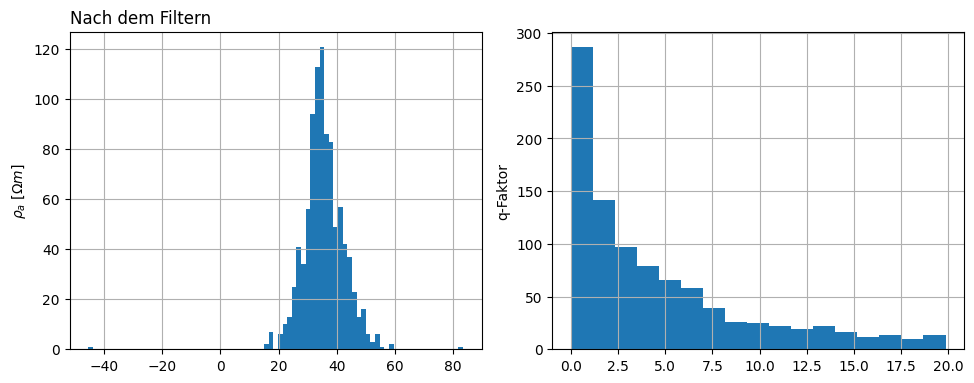

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(25 / 2.54, 10 / 2.54))
ax = axes[0]
ax.set_title('Nach dem Filtern', loc='left')
ERT.data["rhoa"].hist(bins="fd", ax=ax)
ax.set_ylabel(r'$\rho_a~[\Omega m]$')
ax = axes[1]
ERT.data["q"].hist(bins="fd", ax=ax)
ax.set_ylabel('q-Faktor')

fig.tight_layout()

## Pseudosektionen

Zuweisen von Pseudo-positionen zu jedem Datenpunkt.

## Variante 1

Nur zur Veranschaulichung

## Variante 2

* X-Position ist der Mittelpunkt aller vier X-Positionen
* Y-Position

In [41]:
# Beispiel zum Mitteln von Vektoren
bspA = np.array([
    [1, 2],
    [3, 4]
])

np.mean(bspA, axis=1)

array([1.5, 3.5])

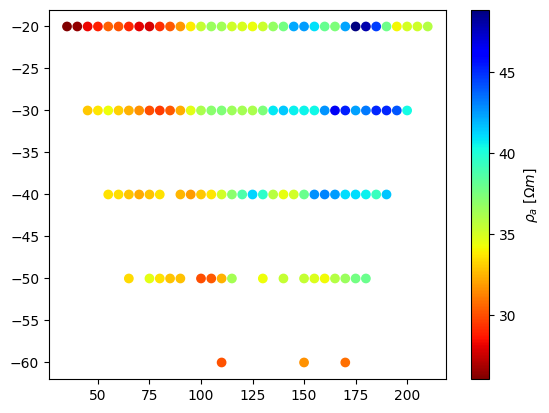

In [42]:
skip = 3
ERT_skip = ERT.data[((ERT.data["b"] - ERT.data["a"]) == skip + 1).values]

x = np.mean(ERT_skip[["a", "b", "m", "n"]].values, axis=1) * 5
y = (np.mean(ERT_skip[["a", "b"]].values, axis=1) - np.mean(ERT_skip[["m", "n"]].values, axis=1)) / 2 * 5

fig, ax = plt.subplots()
sc = ax.scatter(x, y, c=ERT_skip["rhoa"].values, cmap="jet_r")
cb = plt.colorbar(sc)
cb.set_label(r'$\rho_a~[\Omega m]$')

## Variante 2

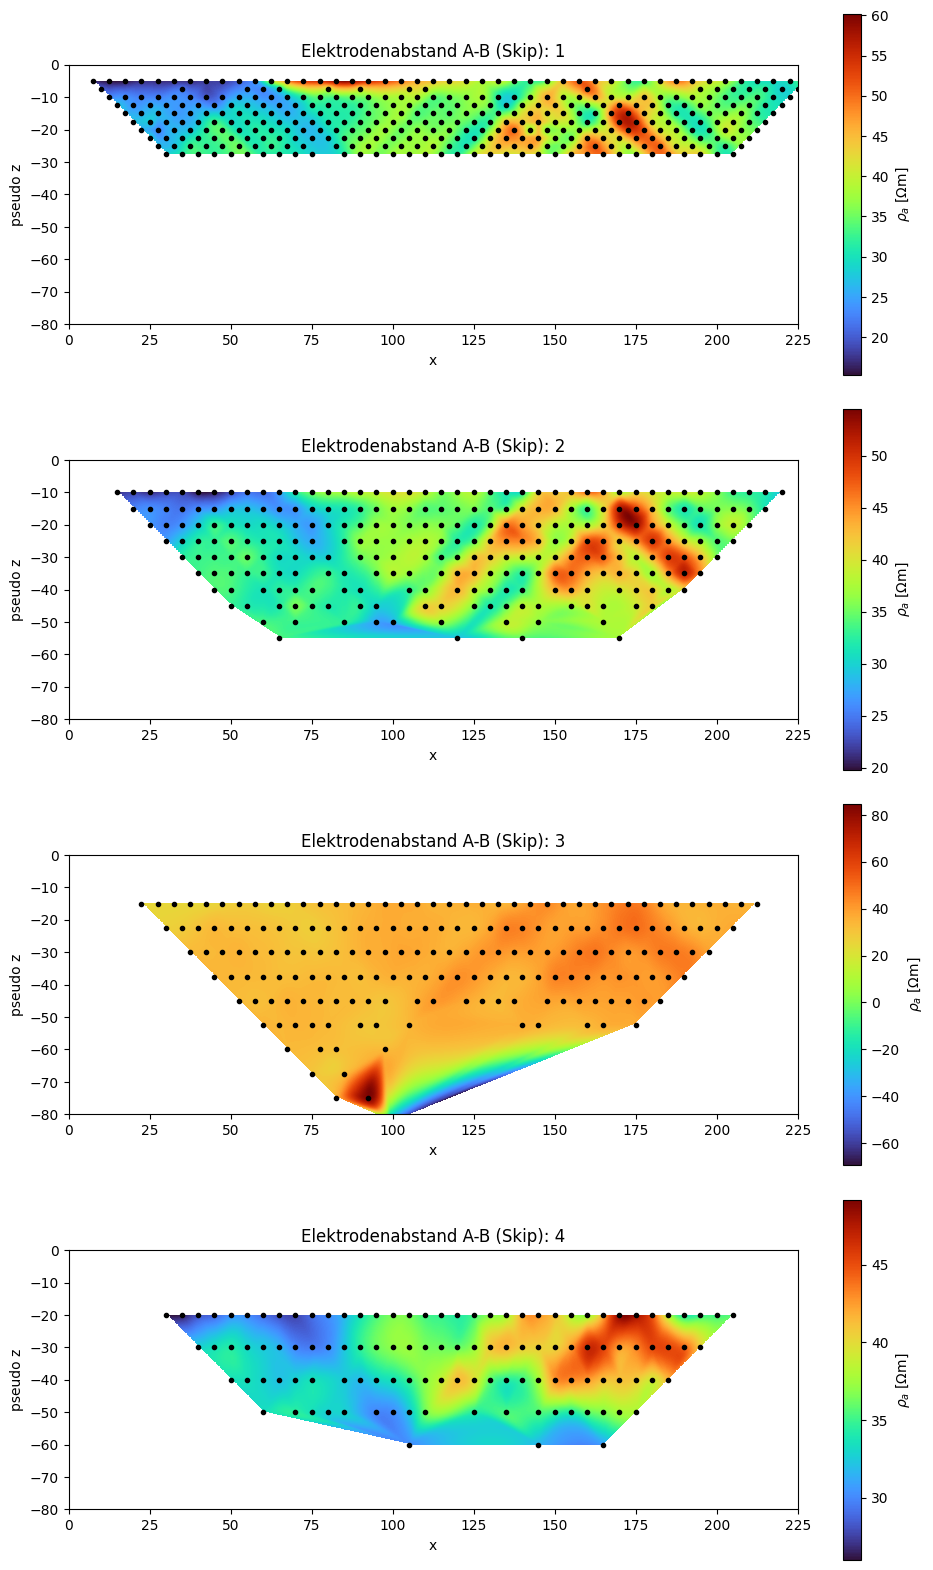

In [43]:
fig, axes = plt.subplots(4, 1, figsize=(10, 16))

for i, skip in enumerate([1, 2, 3, 4]):
    ax = axes[i]
    ax.set_title("Elektrodenabstand A-B (Skip): {}".format(skip))
    ERT_skip = ERT.data[((ERT.data["b"] - ERT.data["a"]) == skip).values]

    ca = ERT.electrode_positions.values[ERT_skip["a"].values - 1, 0]
    cb = ERT.electrode_positions.values[ERT_skip["b"].values - 1, 0]
    cm = ERT.electrode_positions.values[ERT_skip["m"].values - 1, 0]
    cn = ERT.electrode_positions.values[ERT_skip["n"].values - 1, 0]

    pseudo_x = np.mean(np.stack([ca, cb, cm, cn]).T, axis=1)
    pseudo_z = -np.abs(np.mean(np.stack([ca, cb]).T, axis=1) - np.mean(np.stack([cm, cn]).T, axis=1)) / 2

    xi = np.linspace(pseudo_x.min(), pseudo_x.max(), 1000)
    zi = np.linspace(pseudo_z.min(), pseudo_z.max(), 1000)
    xi, zi = np.meshgrid(xi, zi)

    mapp = ax.imshow(
        interpolate.griddata((pseudo_x, pseudo_z),
        ERT_skip["rhoa"],
        (xi, zi), method="cubic"),
        extent=[xi.min(), xi.max(), zi.max(), zi.min()],
        cmap='turbo',
    )
    ax.invert_yaxis()
    # Fixieren der Achsen zur besseren Vergleichbarkeit
    ax.set_xlim(0, 225)
    ax.set_ylim(-80, 0)
    ax.set_xlabel("x")
    ax.set_ylabel("pseudo z")
    ax.scatter(pseudo_x, pseudo_z, color="k", marker=".")

    fig.colorbar(mapp, ax=ax, orientation="vertical", label=r"$\rho_a$ [$\Omega$m]")
    
fig.tight_layout()
# fig.savefig('plots/pseudosection_all_new_rhoa_lin_01.png')

In [44]:
pseudo_z

array([-20., -30., -40., -50., -20., -30., -40., -20., -30., -40., -50.,
       -20., -30., -40., -50., -20., -30., -40., -50., -20., -30., -40.,
       -50., -20., -30., -20., -30., -40., -50., -60., -20., -30., -40.,
       -50., -20., -30., -40., -50., -20., -30., -40., -50., -20., -30.,
       -40., -20., -30., -40., -20., -30., -40., -50., -20., -30., -40.,
       -20., -30., -40., -50., -60., -20., -30., -40., -20., -30., -40.,
       -50., -20., -30., -40., -50., -20., -30., -40., -50., -60., -20.,
       -30., -40., -50., -20., -30., -40., -50., -20., -30., -40., -50.,
       -20., -30., -40., -50., -20., -30., -40., -20., -30., -40., -20.,
       -30., -40., -20., -30., -40., -20., -30., -20., -30., -20., -30.,
       -20., -30., -20., -20., -20., -20.])

In [56]:
# -np.abs(np.mean(np.stack([ca, cb]).T, axis=1) - np.mean(np.stack([cm, cn]).T, axis=1)) / 2
xmin = np.min(np.stack([ca, cb, cm, cn]), axis=0)
xmax = np.max(np.stack([ca, cb, cm, cn]), axis=0)
pseudodepth = - (xmax - xmin) / 5
print(pseudodepth)

[-12. -16. -20. -24. -12. -16. -20. -12. -16. -20. -24. -12. -16. -20.
 -24. -12. -16. -20. -24. -12. -16. -20. -24. -12. -16. -12. -16. -20.
 -24. -28. -12. -16. -20. -24. -12. -16. -20. -24. -12. -16. -20. -24.
 -12. -16. -20. -12. -16. -20. -12. -16. -20. -24. -12. -16. -20. -12.
 -16. -20. -24. -28. -12. -16. -20. -12. -16. -20. -24. -12. -16. -20.
 -24. -12. -16. -20. -24. -28. -12. -16. -20. -24. -12. -16. -20. -24.
 -12. -16. -20. -24. -12. -16. -20. -24. -12. -16. -20. -12. -16. -20.
 -12. -16. -20. -12. -16. -20. -12. -16. -12. -16. -12. -16. -12. -16.
 -12. -12. -12. -12.]
